In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import keras
from keras.optimizers import Adam
from keras.layers import GRU, Dense, Dropout, BatchNormalization, Activation
from keras.models import Model, Sequential
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, Normalizer, PowerTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import IsolationForest
import tensorflow as tf
from sklearn.preprocessing import PowerTransformer
from keras.regularizers import l1_l2

import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

2024-06-12 19:50:04.176457: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 19:50:04.946104: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
vix_data = yf.download('^VIX', start='2008-01-01')
vix_data['VIX_close'] = vix_data['Adj Close']

tnx_data = yf.download('^TNX', start='2008-01-01')
tnx_data['10_Y_close'] = tnx_data['Adj Close'] / 100

irx_data = yf.download('^IRX', start='2008-01-01')
irx_data['3_M_close'] = irx_data['Adj Close'] / 100

vol_df = pd.read_csv('/home/ranksjupyter/notebooks/Ranks/sector_models/vols_pred/volatility_df.csv', 
                     parse_dates=['Date'], index_col='Date')

volatility_df = pd.merge_asof(vol_df, vix_data['VIX_close'], left_index=True, right_index=True, direction='nearest')
volatility_df = pd.merge_asof(volatility_df, tnx_data['10_Y_close'], left_index=True, right_index=True, direction='nearest')
volatility_df = pd.merge_asof(volatility_df, irx_data['3_M_close'], left_index=True, right_index=True, direction='nearest')

volatility_df['Slope'] = volatility_df['10_Y_close'] - volatility_df['3_M_close']
volatility_df = volatility_df.set_index(vol_df.index)
volatility_df.isna().sum()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Recovered_vol                    0
Risk_premium                     0
Risk_preference                  0
Risk_neutral_skewness            0
Risk_neutral_kurtosis            0
Recovered_skewness               0
Recovered_kurtosis               0
USA_10_y_treasuries              0
Effective_Fed_Funds_Rate_true    0
Consumer_Price_Index_true        0
Producer_Price_Index_true        0
Unemployment_Rate_true           0
GDP_true                         0
Industrial_Production_true       0
Mortgage_Rates_true              0
Realized_Volatility              0
VIX_close                        0
10_Y_close                       0
3_M_close                        0
Slope                            0
dtype: int64

In [3]:
volatility_df = volatility_df[['Recovered_vol', 'Risk_premium', 'Risk_preference', 
                               'USA_10_y_treasuries', 'Mortgage_Rates_true', 'VIX_close', 
                               'Slope', 'Realized_Volatility']]

volatility_df = volatility_df.replace([0], 1e-6)

volatility_df = volatility_df / volatility_df.shift(1) - 1

lag = -5
volatility_df[f'Realized_Volatility_(t+{abs(lag)})'] = volatility_df['Realized_Volatility'].shift(lag)
volatility_df = volatility_df.dropna()
# volatility_df.drop('Realized_Volatility', axis=1, inplace=True)
print(len(volatility_df))
volatility_df.head(10)

3357


,Recovered_vol,Risk_premium,Risk_preference,USA_10_y_treasuries,Mortgage_Rates_true,VIX_close,Slope,Realized_Volatility,Realized_Volatility_(t+5)
Date,,,,,,,,,
2010-01-05,-0.024188,-0.842892,0.119724,-0.022390,0.000000,-0.034431,-0.024036,-0.029937,0.031692
2010-01-06,0.001425,0.247562,0.002371,0.014114,0.000000,-0.009819,0.018403,-0.015344,0.029962
2010-01-07,0.007015,0.222614,0.014305,0.003676,0.000000,-0.005219,0.003720,0.005156,-0.022161
2010-01-08,0.030061,-0.979034,-0.110890,-0.003663,0.000000,-0.048793,-0.002383,-0.052279,0.046408
2010-01-11,0.030583,98.432695,0.030537,0.002626,0.022267,-0.031991,0.006635,-0.006034,0.073188
2010-01-12,-0.037054,0.438333,-0.051378,-0.025930,0.000000,0.039886,-0.030055,0.031692,-0.011969
2010-01-13,0.161288,-1.216182,0.260483,0.017209,0.000000,-0.021918,0.014678,0.029962,0.137014
2010-01-14,0.012751,0.520871,0.022884,-0.012953,0.000000,-0.012325,-0.011787,-0.022161,0.125819
2010-01-15,-0.231002,-4.854506,-0.308144,-0.015533,0.000000,0.015882,-0.018433,0.046408,0.002256


In [4]:
# Стандартизация, нормализация, замена выбросов медианой

values_clear = volatility_df.copy()

train_size = int(len(values_clear) * 0.7)
val_size = int(len(values_clear) * 0.15)
test_size = len(values_clear) - train_size - val_size

train = values_clear.iloc[:train_size]
val = values_clear.iloc[train_size:train_size + val_size]
test = values_clear.iloc[train_size + val_size:]

# Обучаем стандартизатор, нормализатор и изолейшн форест на тренировочных данных
transformer = PowerTransformer(method='yeo-johnson')
transformer.fit(train)
train_transformed = transformer.transform(train)

scaler = MinMaxScaler(feature_range=(1e-6, 1))
scaler.fit(train_transformed)
train_scaled = scaler.transform(train_transformed)

isolation_forest = IsolationForest(n_estimators=1000, contamination=0.01, random_state=42) # 0.01
isolation_forest.fit(train_scaled)

normalizer = Normalizer()
normalizer.fit(train_scaled)

# Применяем стандартизатор, нормализатор и изолейшн форест на тренировочных, валидационных и тестовых данных
train_isolation_forest = isolation_forest.predict(train_scaled)
train_normalized = normalizer.transform(train_scaled)

val_transformed = transformer.transform(val)
val_scaled = scaler.transform(val_transformed)
val_isolation_forest = isolation_forest.predict(val_scaled)
val_normalized = normalizer.transform(val_scaled)

test_transformed = transformer.transform(test)
test_scaled = scaler.transform(test_transformed)
test_isolation_forest = isolation_forest.predict(test_scaled)
test_normalized = normalizer.transform(test_scaled)

# Считаем метрику
train_values = np.median(train_normalized, axis=0)
val_values = np.median(val_normalized, axis=0)
test_values = np.median(test_normalized, axis=0)

# Заполняем выбросы медианой
train_normalized[train_isolation_forest == -1] = train_values
val_normalized[val_isolation_forest == -1] = val_values
test_normalized[test_isolation_forest == -1] = test_values

y_train = train_normalized[:, -1:]
y_train = np.squeeze(y_train)
X_train = np.delete(train_normalized, -1, axis=1)

y_val = val_normalized[:, -1:]
y_val = np.squeeze(y_val)
X_val = np.delete(val_normalized, -1, axis=1)

y_test = test_normalized[:, -1:]
y_test = np.squeeze(y_test)
X_test = np.delete(test_normalized, -1, axis=1)

# Reshape
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(2349, 1, 8) (2349,) (503, 1, 8) (503,) (505, 1, 8) (505,)


In [5]:
# GRU

In [6]:
# custom_logcosh

penalty = 5
quantile_threshold = 75
quantile = tf.constant(np.percentile(y_train, quantile_threshold), dtype=tf.float32)

def custom_logcosh(y_true, y_pred):
    error = y_true - y_pred
    mask = tf.cast(y_true > quantile, tf.float32)
    weighted_error = error * (1 + penalty * mask * (y_true - quantile))
    return tf.reduce_sum(tf.math.log(tf.math.cosh(weighted_error)))

In [7]:
n_units = 8
dropout_rate = 0.5
recurrent_dropout_rate = 0.5
activation = 'tanh'
seed = 1
input_model = (X_train.shape[1], X_train.shape[2])
l1_reg = 0.00
l2_reg = 0.00

model = Sequential()

model.add(GRU(
    n_units,
    activation=activation, 
    return_sequences=True,
    input_shape=input_model,
    recurrent_dropout=recurrent_dropout_rate,
    kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
    seed=seed,
))
model.add(Dropout(dropout_rate))

model.add(GRU(
    n_units,
    activation=activation,
    return_sequences=True,
    recurrent_dropout=recurrent_dropout_rate,
    kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
    seed=seed
))
model.add(Dropout(dropout_rate))

model.add(GRU(
    n_units,
    activation=activation,
    recurrent_dropout=recurrent_dropout_rate,
    kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
    seed=seed
))
model.add(Dropout(dropout_rate))

model.add(Dense(1))
model.add(Activation('linear'))

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=custom_logcosh) # keras.losses.log_cosh

history = model.fit(X_train,
                    y_train,
                    epochs=500,
                    batch_size=4,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    shuffle=False,
                    callbacks=[early_stopping])

# Предсказание значений на валидационной выборке
val_pred = model.predict(X_val)
print(f'MSE val: {mean_squared_error(y_val, val_pred):.4f}')
print(f'MAE val: {mean_absolute_error(y_val, val_pred):.4f}')
print(f'R2 val: {r2_score(y_val, val_pred):.4f}')
print(f'MAPE val: {mean_absolute_percentage_error(y_val, val_pred):.4f}')

# Предсказание значений на тестовой выборке
y_pred = model.predict(X_test)
print(f'MSE test: {mean_squared_error(y_test, y_pred):.4f}')
print(f'MAE test: {mean_absolute_error(y_test, y_pred):.4f}')
print(f'R2 test: {r2_score(y_test, y_pred):.4f}')
print(f'MAPE test: {mean_absolute_percentage_error(y_test, y_pred):.4f}')

Epoch 1/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2644 - val_loss: 0.0935
Epoch 2/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0705 - val_loss: 0.0107
Epoch 3/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0285 - val_loss: 0.0040
Epoch 4/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0231 - val_loss: 0.0034
Epoch 5/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0198 - val_loss: 0.0029
Epoch 6/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0172 - val_loss: 0.0027
Epoch 7/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0148 - val_loss: 0.0025
Epoch 8/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0135 - val_loss: 0.0022
Epoch 9/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0101 - val_loss: 0.0022
Epoch 10/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0092 - val_loss: 0.0020
Epoch 11/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0074 - val_loss: 0.0020
Epoch 12/500
588/588 ━━━━━━━━━━━━━━━━━━━━

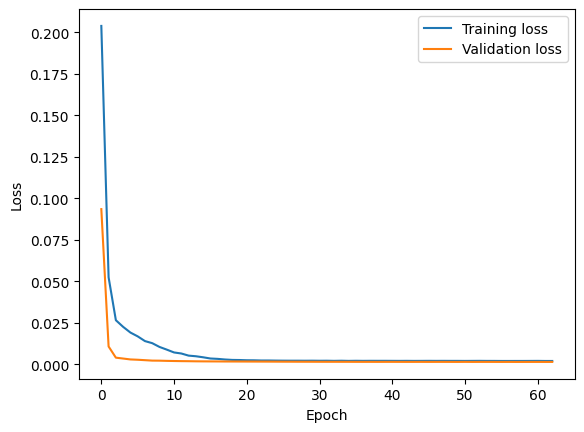

In [8]:
# График лосса

train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots()
ax.plot(train_loss, label='Training loss')
ax.plot(val_loss, label='Validation loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

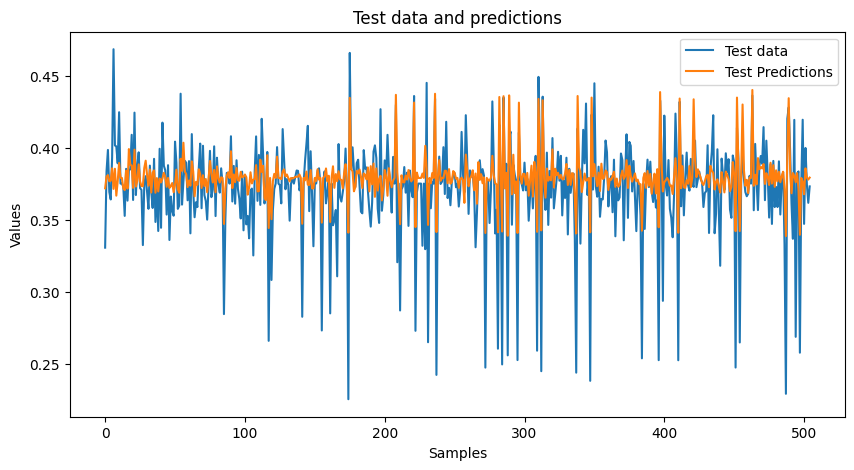

In [9]:
# Построение графика тестовой выборки и прогнозов

plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Test data')
plt.plot(y_pred, label='Test Predictions')
plt.title('Test data and predictions')
plt.xlabel('Samples')
plt.ylabel('Values') 
plt.legend()
plt.show()

In [10]:
# keras.losses.log_cosh

n_units = 8
dropout_rate = 0.5
recurrent_dropout_rate = 0.5
activation = 'tanh'
seed = 1
input_model = (X_train.shape[1], X_train.shape[2])
l1_reg = 0.00
l2_reg = 0.00

model = Sequential()

model.add(GRU(
    n_units,
    activation=activation, 
    return_sequences=True,
    input_shape=input_model,
    recurrent_dropout=recurrent_dropout_rate,
    kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
    seed=seed,
))
model.add(Dropout(dropout_rate))

model.add(GRU(
    n_units,
    activation=activation,
    return_sequences=True,
    recurrent_dropout=recurrent_dropout_rate,
    kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
    seed=seed
))
model.add(Dropout(dropout_rate))

model.add(GRU(
    n_units,
    activation=activation,
    recurrent_dropout=recurrent_dropout_rate,
    kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg),
    seed=seed
))
model.add(Dropout(dropout_rate))

model.add(Dense(1))
model.add(Activation('linear'))

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=keras.losses.log_cosh) # keras.losses.log_cosh

history = model.fit(X_train,
                    y_train,
                    epochs=500,
                    batch_size=4,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    shuffle=False,
                    callbacks=[early_stopping])

# Предсказание значений на валидационной выборке
val_pred_log_cosh = model.predict(X_val)
print(f'MSE val: {mean_squared_error(y_val, val_pred_log_cosh):.4f}')
print(f'MAE val: {mean_absolute_error(y_val, val_pred_log_cosh):.4f}')
print(f'R2 val: {r2_score(y_val, val_pred):.4f}')
print(f'MAPE val: {mean_absolute_percentage_error(y_val, val_pred):.4f}')

# Предсказание значений на тестовой выборке
y_pred_log_cosh = model.predict(X_test)
print(f'MSE test: {mean_squared_error(y_test, y_pred_log_cosh):.4f}')
print(f'MAE test: {mean_absolute_error(y_test, y_pred_log_cosh):.4f}')
print(f'R2 test: {r2_score(y_test, y_pred_log_cosh):.4f}')
print(f'MAPE test: {mean_absolute_percentage_error(y_test, y_pred_log_cosh):.4f}')

Epoch 1/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0517 - val_loss: 0.0080
Epoch 2/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0132 - val_loss: 0.0023
Epoch 3/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0083 - val_loss: 0.0014
Epoch 4/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0066 - val_loss: 0.0010
Epoch 5/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0047 - val_loss: 5.8462e-04
Epoch 6/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0041 - val_loss: 5.8254e-04
Epoch 7/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0034 - val_loss: 5.8891e-04
Epoch 8/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0027 - val_loss: 4.8212e-04
Epoch 9/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0024 - val_loss: 4.5799e-04
Epoch 10/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0020 - val_loss: 4.6459e-04
Epoch 11/500
588/588 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0017 - val_loss: 4.2286e-04
Epoch 12/500


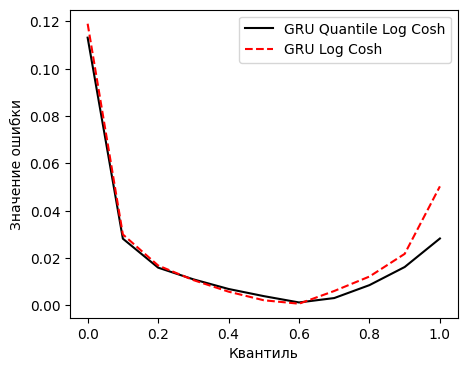

In [11]:
# GRU quantile logcosh
quan = []
for q in np.arange(0, 1.1, 0.1):
    quantile_error = np.abs(np.quantile(y_test, q) - np.quantile(y_pred, q))
    quan.append(quantile_error)
quan_df = pd.DataFrame(quan, columns=['GRU quantile logcosh'])
index = np.arange(0, len(quan_df)*0.1, 0.1)
quan_df.set_index(index, inplace=True)

# GRU logcosh
quan_log_cosh = []
for q in np.arange(0, 1.1, 0.1):
    quantile_error = np.abs(np.quantile(y_test, q) - np.quantile(y_pred_log_cosh, q))
    quan_log_cosh.append(quantile_error)
    
quan_df_log_cosh = pd.DataFrame(quan_log_cosh, columns=['GRU logcosh'])
index = np.arange(0, len(quan_df_log_cosh)*0.1, 0.1)
quan_df_log_cosh.set_index(index, inplace=True)

quan_df['GRU logcosh'] = quan_df_log_cosh

plt.figure(figsize=(5, 4))
plt.plot(quan_df['GRU quantile logcosh'], color='black', label='GRU Quantile Log Cosh')
plt.plot(quan_df['GRU logcosh'], color='red', label='GRU Log Cosh', linestyle='--')
plt.legend()
plt.xlabel('Квантиль')
plt.ylabel('Значение ошибки')

plt.savefig('gru_q_errors_rob_check.svg', format='svg')

plt.show()